# Retraining more of the VGG Architecture

Training the last layer worked better than adding a linear layer after. So let's train more than just the last layer.

## Set Up Model, Load Weights

In [1]:
path = '../../../data/dogscats/'
model_path = path + 'models/'

Load vanilla VGG16 model:

In [2]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Using Theano backend.
/home/matt/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


Update last layer per previous training exercise, load weights in:

In [3]:
from keras.layers import Dense
from keras.optimizers import RMSprop
model.pop()
for layer in model.layers: layer.trainable = False
model.add(Dense(2, activation='softmax'))
opt = RMSprop(lr=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(model_path + 'finetune1.h5')

## Modify Architecture and Unfreeze More Layers

Unfreeze all the fully-connected layers:

In [4]:
first_dense_idx = [index for index,layer in enumerate(model.layers) if type(layer) is Dense][0]
for layer in model.layers[first_dense_idx:]: layer.trainable = True

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

## Train the Unlocked Layers

In [6]:
import numpy as np
from importlib import reload
import utils; reload(utils)
from utils import get_batches

# Load up the labels
# Use batch size of 1 since we're just doing preprocessing on the CPU
from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

# Load Data
batch_size = 100
import bcolz
from keras.preprocessing import image
def load_array(fname): return bcolz.open(fname)[:]
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [7]:
# Define Training
fit_batch_size = 250
def fit_model(model, batches, val_batches, epochs=1):
    model.fit_generator(batches, 
                        steps_per_epoch=batches.n/fit_batch_size, 
                        epochs=epochs, 
                        validation_data=val_batches, 
                        validation_steps=val_batches.n/fit_batch_size)

# Train 
from keras import backend as K
K.set_value(opt.lr, 0.00075)
fit_model(model, batches, val_batches, 4)

Epoch 1/4
92/92 [==============================] - 39s - loss: 0.0855 - acc: 0.9793 - val_loss: 0.0963 - val_acc: 0.9675
Epoch 2/4
92/92 [==============================] - 39s - loss: 0.0862 - acc: 0.9813 - val_loss: 0.0774 - val_acc: 0.9700
Epoch 3/4
92/92 [==============================] - 39s - loss: 0.0867 - acc: 0.9762 - val_loss: 0.0797 - val_acc: 0.9813
Epoch 4/4
92/92 [==============================] - 39s - loss: 0.0980 - acc: 0.9778 - val_loss: 0.0560 - val_acc: 0.9850


In [8]:
fit_model(model, batches, val_batches, 4)

Epoch 1/4
92/92 [==============================] - 39s - loss: 0.0785 - acc: 0.9811 - val_loss: 0.0925 - val_acc: 0.9763
Epoch 2/4
92/92 [==============================] - 39s - loss: 0.0720 - acc: 0.9815 - val_loss: 0.0514 - val_acc: 0.9863
Epoch 3/4
92/92 [==============================] - 39s - loss: 0.0804 - acc: 0.9793 - val_loss: 0.0323 - val_acc: 0.9900
Epoch 4/4
92/92 [==============================] - 39s - loss: 0.0805 - acc: 0.9803 - val_loss: 0.0391 - val_acc: 0.9875


In [9]:
fit_model(model, batches, val_batches, 2)

Epoch 1/2
92/92 [==============================] - 39s - loss: 0.0787 - acc: 0.9803 - val_loss: 0.0485 - val_acc: 0.9888
Epoch 2/2
92/92 [==============================] - 39s - loss: 0.0893 - acc: 0.9783 - val_loss: 0.0204 - val_acc: 0.9913


In [36]:
#model.save_weights(model_path + 'finetune2.h5')
model.load_weights(model_path + 'finetune2.h5')

## Evaluate

In [11]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 8s     


[0.052600809357617434, 0.98499999999999999]

In [12]:
preds = model.predict_classes(val_data, batch_size=100)
probs = model.predict_proba(val_data, batch_size=100)[:,0]

2000/2000 [==============================] - 8s     


[[992   8]
 [ 22 978]]


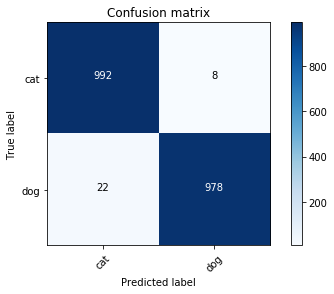

In [13]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Test Data

In [15]:
# Load up the labels
# Use batch size of 1 since we're just doing preprocessing on the CPU
from utils import get_data
tst_batches = get_batches(path+'test-redux', shuffle=False, batch_size=1)
tst_classes = tst_batches.classes
tst_labels = onehot(tst_classes)

# Load the data
tst_data = get_data(path+'test-redux')

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.


In [23]:
tst_probs = model.predict_proba(tst_data, batch_size=100)[:,0]

12500/12500 [==============================] - 49s    


In [27]:
prob_dog = np.array(1-tst_probs)
prob_dog_clipped = prob_dog.clip(min=0.005, max=0.995)

idx = [int(fn.split('/')[1].split('.')[0]) for fn in tst_batches.filenames]

prob_dog_idx = np.c_[np.array(idx), prob_dog_clipped]

In [28]:
prob_dog_idx[:5]

array([[  3.4960e+03,   5.0000e-03],
       [  1.0203e+04,   9.9500e-01],
       [  1.9230e+03,   5.0000e-03],
       [  2.0560e+03,   9.9500e-01],
       [  8.5060e+03,   5.0000e-03]])

In [29]:
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")

## Try unlocking more layers?

In [37]:
for layer in model.layers[12:]: layer.trainable=True

In [38]:
K.set_value(opt.lr, 0.0006)
fit_model(model, batches, val_batches, 4)

Epoch 1/4
92/92 [==============================] - 39s - loss: 0.0760 - acc: 0.9798 - val_loss: 0.0322 - val_acc: 0.9875
Epoch 2/4
92/92 [==============================] - 40s - loss: 0.0601 - acc: 0.9815 - val_loss: 0.0742 - val_acc: 0.9750
Epoch 3/4
92/92 [==============================] - 40s - loss: 0.0749 - acc: 0.9818 - val_loss: 0.0513 - val_acc: 0.9863
Epoch 4/4
92/92 [==============================] - 40s - loss: 0.0807 - acc: 0.9822 - val_loss: 0.0199 - val_acc: 0.9950


In [39]:
model.save_weights(model_path + 'finetune3.h5')
#model.load_weights(model_path + 'finetune3.h5')

## Evaluate

In [40]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 8s     


[0.056378833034132186, 0.98250000000000004]

In [41]:
preds = model.predict_classes(val_data, batch_size=100)
probs = model.predict_proba(val_data, batch_size=100)[:,0]

2000/2000 [==============================] - 8s     


[[971  29]
 [  6 994]]


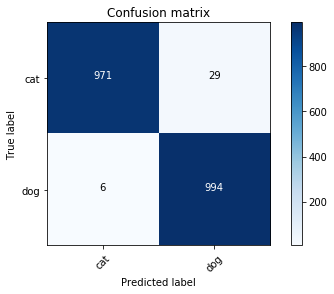

In [42]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

## Test

In [43]:
tst_probs = model.predict_proba(tst_data, batch_size=100)[:,0]

12500/12500 [==============================] - 50s    


In [44]:
prob_dog = np.array(1-tst_probs)
prob_dog_clipped = prob_dog.clip(min=0.01, max=0.99)

idx = [int(fn.split('/')[1].split('.')[0]) for fn in tst_batches.filenames]

prob_dog_idx = np.c_[np.array(idx), prob_dog_clipped]
prob_dog_idx[:5]

array([[  3.4960e+03,   1.0000e-02],
       [  1.0203e+04,   9.9000e-01],
       [  1.9230e+03,   1.0000e-02],
       [  2.0560e+03,   9.9000e-01],
       [  8.5060e+03,   1.0000e-02]])

In [45]:
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")